# Final assignment
Hannah Weiser \
Heidelberg University \
Institute of Geography \
Advanced Geoscripting \
Summer term 2020

The goal of the project is to perform an explorative data analysis on specific species of digger wasps and their prey. We are using the GBIF (Global Biodiversity Information Facility) API. GBIF provides free and open access to biodiversity data (https://www.gbif.org/).

First, we import the packages

In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pygbif import occurrences as occ  # python client for the GBIF API 
from pygbif import maps
import mplleaflet
plt.style.use('seaborn')
import geopandas as gpd
%matplotlib inline

And then download occurence data of *Isodontia mexicana*.

In [50]:
isodontia_dict = occ.search(scientificName = 'Isodontia mexicana')
isodontia_occs = isodontia_dict['results']

Let's display all keys (in the first occurence).

In [3]:
display(isodontia_occs[0].keys())

dict_keys(['key', 'datasetKey', 'publishingOrgKey', 'installationKey', 'publishingCountry', 'protocol', 'lastCrawled', 'lastParsed', 'crawlId', 'extensions', 'basisOfRecord', 'occurrenceStatus', 'taxonKey', 'kingdomKey', 'phylumKey', 'classKey', 'orderKey', 'familyKey', 'genusKey', 'speciesKey', 'acceptedTaxonKey', 'scientificName', 'acceptedScientificName', 'kingdom', 'phylum', 'order', 'family', 'genus', 'species', 'genericName', 'specificEpithet', 'taxonRank', 'taxonomicStatus', 'dateIdentified', 'decimalLongitude', 'decimalLatitude', 'coordinateUncertaintyInMeters', 'stateProvince', 'year', 'month', 'day', 'eventDate', 'issues', 'modified', 'lastInterpreted', 'references', 'license', 'identifiers', 'media', 'facts', 'relations', 'gadm', 'geodeticDatum', 'class', 'countryCode', 'recordedByIDs', 'identifiedByIDs', 'country', 'rightsHolder', 'identifier', 'http://unknown.org/nick', 'verbatimEventDate', 'datasetName', 'gbifID', 'collectionCode', 'verbatimLocality', 'occurrenceID', 'tax

What's the geodetic datum of the first occurence?

In [4]:
print(isodontia_occs[0]['geodeticDatum'])

WGS84


For further analyses, we want to work with a dataframe instead of a dictionary.

In [51]:
df_isodontia = pd.DataFrame.from_dict(isodontia_occs)
display(df_isodontia.head())
#convert some date columns to datetime
df_isodontia = df_isodontia.astype({'eventDate':'datetime64', 'dateIdentified':'datetime64'})

,key,datasetKey,publishingOrgKey,installationKey,publishingCountry,protocol,lastCrawled,lastParsed,crawlId,extensions,...,sex,lifeStage,eventRemarks,taxonRemarks,organismRemarks,collectionID,individualCount,continent,dataGeneralizations,higherClassification
0,2597845815,50c9509d-22c7-4a22-a47d-8c48425ef4a7,28eb1a3f-1c15-4a95-931a-4af90ecb574d,997448a8-f762-11e1-a439-00145eb45e9a,US,DWC_ARCHIVE,2020-11-01T14:40:23.781+0000,2020-11-01T15:56:23.096+0000,238,{},...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2603300247,50c9509d-22c7-4a22-a47d-8c48425ef4a7,28eb1a3f-1c15-4a95-931a-4af90ecb574d,997448a8-f762-11e1-a439-00145eb45e9a,US,DWC_ARCHIVE,2020-11-01T14:40:23.781+0000,2020-11-01T16:12:28.193+0000,238,{},...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2626578683,50c9509d-22c7-4a22-a47d-8c48425ef4a7,28eb1a3f-1c15-4a95-931a-4af90ecb574d,997448a8-f762-11e1-a439-00145eb45e9a,US,DWC_ARCHIVE,2020-11-01T14:40:23.781+0000,2020-11-01T16:13:51.389+0000,238,{},...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2634131701,50c9509d-22c7-4a22-a47d-8c48425ef4a7,28eb1a3f-1c15-4a95-931a-4af90ecb574d,997448a8-f762-11e1-a439-00145eb45e9a,US,DWC_ARCHIVE,2020-11-01T14:40:23.781+0000,2020-11-01T15:57:04.229+0000,238,{},...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2634531585,50c9509d-22c7-4a22-a47d-8c48425ef4a7,28eb1a3f-1c15-4a95-931a-4af90ecb574d,997448a8-f762-11e1-a439-00145eb45e9a,US,DWC_ARCHIVE,2020-11-01T14:40:23.781+0000,2020-11-01T16:13:38.922+0000,238,{},...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Let's also save this to a csv-file immediately, so our workflow will be really reproducible.

In [52]:
df_isodontia.to_csv("gbif_occ_isodontia_mexicana.csv")

For now, we are only interested in the locations and the event date and only want occurences within europe. We should convert our dataframe to a geodataframe.

For plotting later, we have to make sure our Lat and Long columns do not contain NaN values, otherwise we will not get a plot with mplleaflet basemap.
Let's check if there are NaNs.

In [53]:
print(df_isodontia[['decimalLatitude', 'decimalLongitude']].isnull().sum().sum())

2


Looks like we have an entry with NaN values. We remove it with the `pd.dropna()` method.

In [54]:
df_isodontia = df_isodontia.dropna(subset=['decimalLatitude', 'decimalLongitude'])
gdf_isodontia = gpd.GeoDataFrame(df_isodontia, geometry=gpd.points_from_xy(df_isodontia.decimalLongitude, df_isodontia.decimalLatitude))
display(gdf_isodontia.head())

,key,datasetKey,publishingOrgKey,installationKey,publishingCountry,protocol,lastCrawled,lastParsed,crawlId,extensions,...,lifeStage,eventRemarks,taxonRemarks,organismRemarks,collectionID,individualCount,continent,dataGeneralizations,higherClassification,geometry
0,2597845815,50c9509d-22c7-4a22-a47d-8c48425ef4a7,28eb1a3f-1c15-4a95-931a-4af90ecb574d,997448a8-f762-11e1-a439-00145eb45e9a,US,DWC_ARCHIVE,2020-11-01T14:40:23.781+0000,2020-11-01T15:56:23.096+0000,238,{},...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-100.38803 20.52219)
1,2603300247,50c9509d-22c7-4a22-a47d-8c48425ef4a7,28eb1a3f-1c15-4a95-931a-4af90ecb574d,997448a8-f762-11e1-a439-00145eb45e9a,US,DWC_ARCHIVE,2020-11-01T14:40:23.781+0000,2020-11-01T16:12:28.193+0000,238,{},...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-97.88640 30.20881)
2,2626578683,50c9509d-22c7-4a22-a47d-8c48425ef4a7,28eb1a3f-1c15-4a95-931a-4af90ecb574d,997448a8-f762-11e1-a439-00145eb45e9a,US,DWC_ARCHIVE,2020-11-01T14:40:23.781+0000,2020-11-01T16:13:51.389+0000,238,{},...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-92.92551 45.00075)
3,2634131701,50c9509d-22c7-4a22-a47d-8c48425ef4a7,28eb1a3f-1c15-4a95-931a-4af90ecb574d,997448a8-f762-11e1-a439-00145eb45e9a,US,DWC_ARCHIVE,2020-11-01T14:40:23.781+0000,2020-11-01T15:57:04.229+0000,238,{},...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (7.83430 48.01588)
4,2634531585,50c9509d-22c7-4a22-a47d-8c48425ef4a7,28eb1a3f-1c15-4a95-931a-4af90ecb574d,997448a8-f762-11e1-a439-00145eb45e9a,US,DWC_ARCHIVE,2020-11-01T14:40:23.781+0000,2020-11-01T16:13:38.922+0000,238,{},...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (8.68147 49.39040)


In [55]:
print(gdf_isodontia[['decimalLatitude', 'decimalLongitude']].isnull().sum().sum())

0


Let's see if we can plot it now. We will colour the points of occurences by the eventDate to see if we can get an idea how the species was spreading. 

In [10]:
fig, ax = plt.subplots(figsize=((20,20)))
gdf_isodontia.plot(ax=ax, c=gdf_isodontia['eventDate'], cmap='Blues')
#plt.colorbar()
mplleaflet.display(fig=fig)

c:\users\hannah\anaconda3\envs\gbif\lib\site-packages\mplleaflet\mplexporter\exporter.py:263: MatplotlibDeprecationWarning: 
The get_offset_position function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  offset_order = offset_dict[collection.get_offset_position()]
c:\users\hannah\anaconda3\envs\gbif\lib\site-packages\IPython\core\display.py:717: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


We now want to look at one of the preys of this species and its distribution. Let's get the data. We will write a function, so we can easily retrieve the data for many species.

In [11]:
def species_occurences_to_gdf(species_name):
    occ_dict = occ.search(scientificName=species_name)
    occ_df = pd.DataFrame.from_dict(occ_dict['results'])
    occ_df = occ_df.astype({'dateIdentified':'datetime64'})
    occ_df = occ_df.dropna(subset=['decimalLatitude', 'decimalLongitude'])
    occ_df.to_csv("gbif_occ_" + species_name.replace(" ","_") + ".csv")
    occ_gdf = gpd.GeoDataFrame(occ_df, geometry=gpd.points_from_xy(occ_df.decimalLongitude, occ_df.decimalLatitude))
    return occ_gdf

In [12]:
colors=["blue", "orange", "red"]
plots = []
fig, ax = plt.subplots(figsize=((20,20)))
species_list = ['Isodontia mexicana', 'Meconema meridionale', 'Meconema thalassinum']
for i, species in enumerate(species_list): 
    df = species_occurences_to_gdf(species)
    plots.append(df.plot(ax=ax, c=colors[i]))

#plt.legend(handles=plots, labels=species)
#plt.show()
mplleaflet.display(fig=fig)

c:\users\hannah\anaconda3\envs\gbif\lib\site-packages\mplleaflet\mplexporter\exporter.py:263: MatplotlibDeprecationWarning: 
The get_offset_position function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  offset_order = offset_dict[collection.get_offset_position()]
c:\users\hannah\anaconda3\envs\gbif\lib\site-packages\IPython\core\display.py:717: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


(Unfortunately, mplleaflet does not let us plot legends.)

Interesting. We want to limit our further analysis to Europe. There is a continent tag in gbif, but it is not used in our dataset. We could furthermore filter by countries but then we would have to list them all. So let's just get another geometry of the entire Europe and use the `GeoSeries.within()` method.

The administrative data (`NUTS_BN_60M_2021_3857_LEVL_0.shp`) is downloaded from here: https://ec.europa.eu/eurostat/de/web/gisco/geodata/reference-data/administrative-units-statistical-units/nuts#nuts21


In [13]:
fp = "./NUTS_RG_60M_2021_4326_LEVL_0.shp/NUTS_RG_60M_2021_4326_LEVL_0.shp"
gdf_european_countries = gpd.read_file(fp)

Let's check the GeoDataFrame to see if the download worked.

In [14]:
gdf_european_countries.head()

,NUTS_ID,LEVL_CODE,CNTR_CODE,NAME_LATN,NUTS_NAME,MOUNT_TYPE,URBN_TYPE,COAST_TYPE,FID,geometry
0,DK,0,DK,Danmark,Danmark,0,None,None,DK,"MULTIPOLYGON (((10.19900 56.68400, 10.81800 56..."
1,RS,0,RS,Serbia,Srbija/Сpбија,0,None,None,RS,"POLYGON ((21.47900 45.19300, 21.35800 44.82200..."
2,EE,0,EE,Eesti,Eesti,0,None,None,EE,"MULTIPOLYGON (((27.35700 58.78700, 27.64500 57..."
3,EL,0,EL,Elláda,Ελλάδα,0,None,None,EL,"MULTIPOLYGON (((26.03300 40.73000, 25.63200 40..."
4,ES,0,ES,España,España,0,None,None,ES,"MULTIPOLYGON (((-7.03200 43.54400, -5.85400 43..."


Let's unify them to get one geometry with the entire europe.

In [15]:
gdf_europe = gdf_european_countries.dissolve(by="LEVL_CODE")[['geometry']]
display(gdf_europe)

,geometry
LEVL_CODE,
0,"MULTIPOLYGON (((55.85000 -21.18600, 55.78600 -..."


Looks good. We now use the `Geopandas.clip()` method to only get observations within europe. We'll get a CRS if we do not set the CRS for the `gdf_isodontia` dataframe first. So that will be the first step.

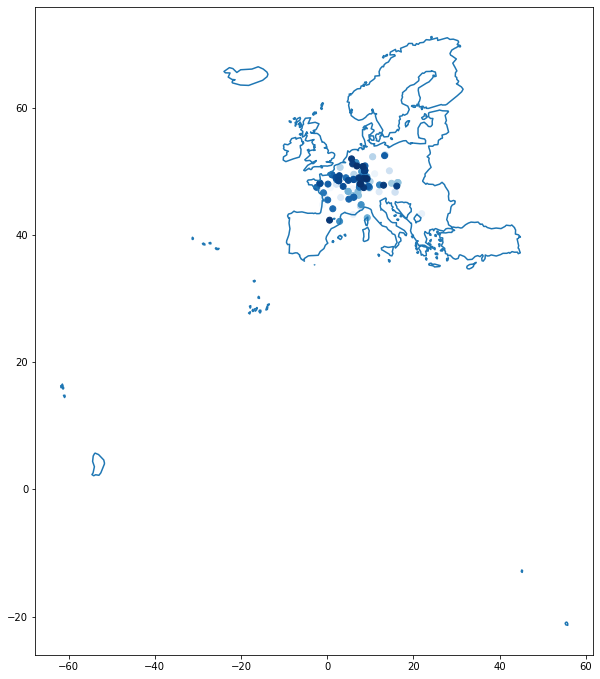

In [56]:
gdf_isodontia.set_crs(epsg=4326, inplace=True)
gdf_isodontia_europe = gpd.clip(gdf_isodontia, gdf_europe)
fig, ax = plt.subplots(figsize=(10,30))
gdf_europe.geometry.boundary.plot(ax=ax)
gdf_isodontia_europe.plot(ax=ax, c=gdf_isodontia['eventDate'], cmap='Blues');

Let's adapt our previous function to clip any extracted species to the extent given by another gdf. 

In [17]:
def download_occs(species_name):
    occ_dict = occ.search(scientificName=species_name)
    return occ_dict

def occs_to_gdf_clip(species_dict, clip_gdf):
    occ_df = pd.DataFrame.from_dict(species_dict['results'])
    occ_df = occ_df.dropna(subset=['decimalLatitude', 'decimalLongitude'])
    occ_df.to_csv("gbif_occ_" + species_dict['results'][0]['scientificName'].replace(" ","_") + ".csv")
    occ_gdf = gpd.GeoDataFrame(occ_df, geometry=gpd.points_from_xy(occ_df.decimalLongitude, occ_df.decimalLatitude))
    clip_crs = clip_gdf.crs
    occ_gdf.set_crs(clip_crs, inplace=True)
    occ_gdf_clipped = gpd.clip(occ_gdf, clip_gdf)

    return occ_gdf_clipped

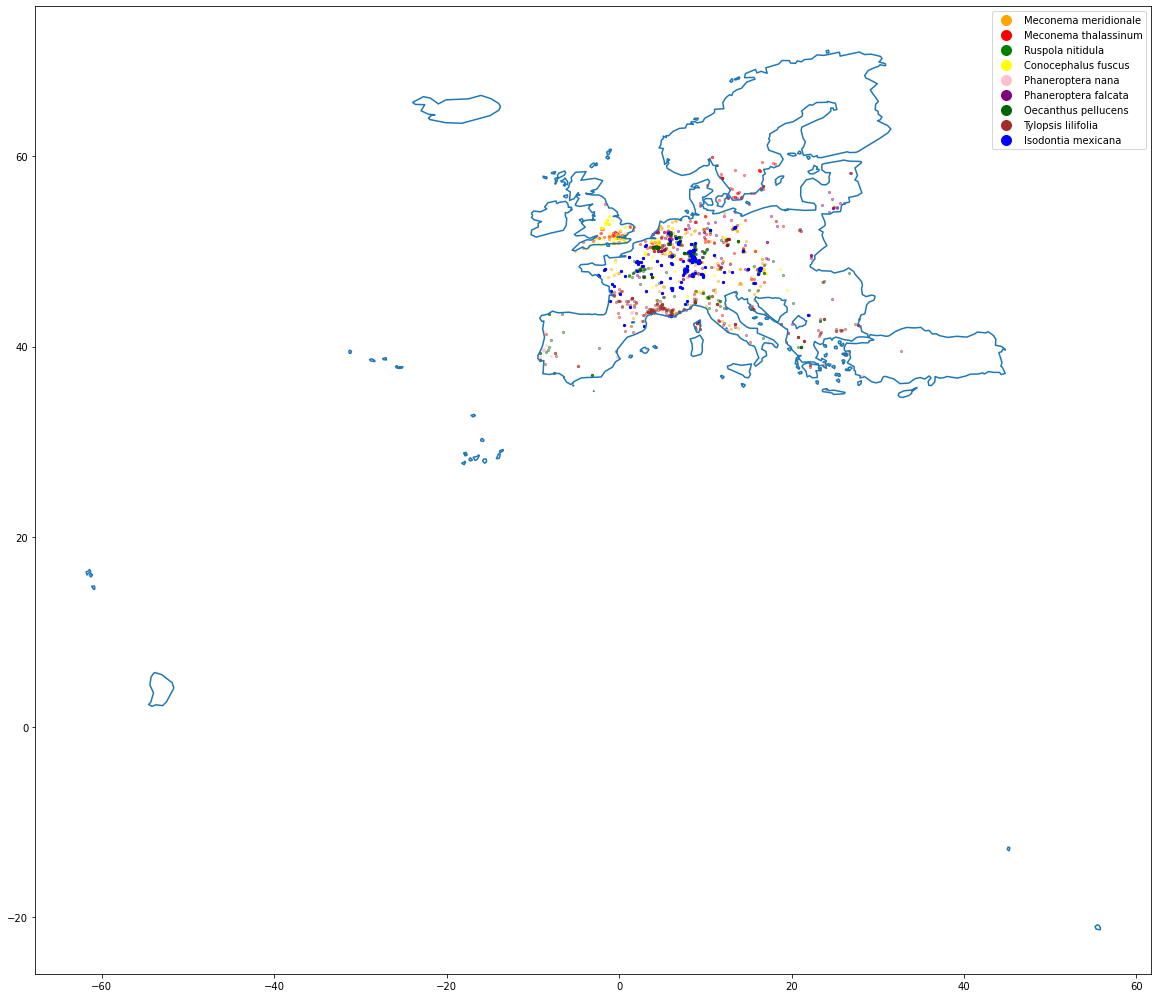

In [18]:
colors=['orange', 'red', 'green', 'yellow', 'pink', 'purple', 'darkgreen', 'brown', 'blue']
fig, ax = plt.subplots(figsize=((20,20)))
species_list = [ 'Meconema meridionale', 
                'Meconema thalassinum', 
                'Ruspola nitidula', 
                'Conocephalus fuscus',
                'Phaneroptera nana',
                'Phaneroptera falcata',
                'Oecanthus pellucens',
                'Tylopsis lilifolia',
                'Isodontia mexicana']
all_gdfs = []
for i, species in enumerate(species_list):
    occs_dict = download_occs(species)
    alpha = 0.4
    if occs_dict['results'] != []: # avoid error in case of empty result
        gdf = occs_to_gdf_clip(occs_dict, gdf_europe)
        all_gdfs.append(gdf)
        if i == len(species_list)-1:
            alpha=1.0
        gdf.plot(ax=ax, c=colors[i], markersize=5, alpha=alpha)
handles = [ plt.plot([],[], marker="o", ms=10, ls="", mec=None, color=colors[i], 
            label="{:s}".format(species_list[i]) )[0]  for i in range(len(species_list)) ]
gdf_europe.geometry.boundary.plot(ax=ax)
ax.legend(handles=handles)
plt.show()

The gbif search is limited to 300 occurences. They are sorted descending by date, which is why we only got occurences from 2020 and 2019 before. To be able to conduct some (spatio-)temporal analysis, let's limit the occurences to germany.

In [24]:
def occs_to_gdf(species_dict):
    occ_df = pd.DataFrame.from_dict(species_dict['results'])
    occ_df = occ_df.dropna(subset=['decimalLatitude', 'decimalLongitude'])
    occ_df = occ_df.astype({'dateIdentified':'datetime64'})
    occ_df.to_csv("gbif_occ_" + species_dict['results'][0]['scientificName'].replace(" ","_") + ".csv")
    occ_gdf = gpd.GeoDataFrame(occ_df, geometry=gpd.points_from_xy(occ_df.decimalLongitude, occ_df.decimalLatitude))

    return occ_gdf

In [25]:
isodontia_occ_dict_ger = occ.search(scientificName='Isodontia mexicana', country='DE')
gdf_isodontia_ger = occs_to_gdf(isodontia_occ_dict_ger)

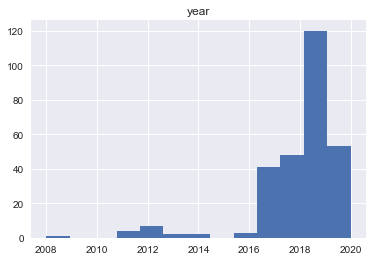

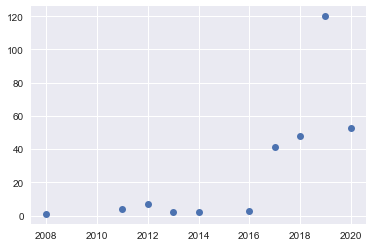

In [66]:
isodontia_ger_date_df = pd.DataFrame(gdf_isodontia_ger['year'])
isodontia_ger_date_df.hist(bins=13)
isodontia_ger_date_df['year'] = pd.to_datetime(isodontia_ger_date_df['year'], format='%Y')
plt.show()
year, number = np.unique(isodontia_ger_date_df, return_counts=True)
plt.plot_date(year, number);

We could furthermore look in which months the species was found.

In [48]:
isodontia_ger_month_df = pd.DataFrame(gdf_isodontia_ger['month'])
month_nums = [1,2,3,4,5,6,7,8,9,10,11,12]
month_names = ['January','February','March','April','May','June','July','August','September','October','November','December']

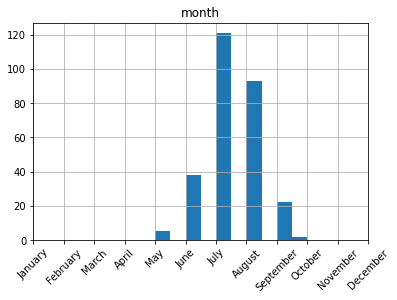

In [49]:
isodontia_ger_month_df.hist()
plt.xticks(ticks=month_nums, labels=month_names, rotation=45)
plt.show()

So in germany, most occurences happened in July and August.

In [80]:
fig, ax = plt.subplots(figsize=(10,10))
gdf_isodontia_ger.plot(ax=ax, column='eventDate', cmap='Blues')
mplleaflet.display(fig=fig)

c:\users\hannah\anaconda3\envs\gbif\lib\site-packages\mplleaflet\mplexporter\exporter.py:263: MatplotlibDeprecationWarning: 
The get_offset_position function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  offset_order = offset_dict[collection.get_offset_position()]
c:\users\hannah\anaconda3\envs\gbif\lib\site-packages\IPython\core\display.py:717: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


,NUTS_ID,LEVL_CODE,CNTR_CODE,NAME_LATN,NUTS_NAME,MOUNT_TYPE,URBN_TYPE,COAST_TYPE,FID,geometry
139,DE736,3,DE,Waldeck-Frankenberg,Waldeck-Frankenberg,4,3,3,DE736,"POLYGON ((9.15541 51.44267, 9.16673 51.37686, ..."
140,DE737,3,DE,Werra-Meißner-Kreis,Werra-Meißner-Kreis,2,3,3,DE737,"POLYGON ((9.92834 51.37530, 9.95493 51.30432, ..."
141,DE803,3,DE,"Rostock, Kreisfreie Stadt","Rostock, Kreisfreie Stadt",4,2,1,DE803,"POLYGON ((11.99909 54.17475, 12.12912 54.18569..."
142,DE804,3,DE,"Schwerin, Kreisfreie Stadt","Schwerin, Kreisfreie Stadt",4,3,2,DE804,"POLYGON ((11.30195 53.65295, 11.44947 53.68068..."
143,DE80J,3,DE,Mecklenburgische Seenplatte,Mecklenburgische Seenplatte,4,3,3,DE80J,"POLYGON ((12.98671 54.00397, 13.18150 53.93113..."


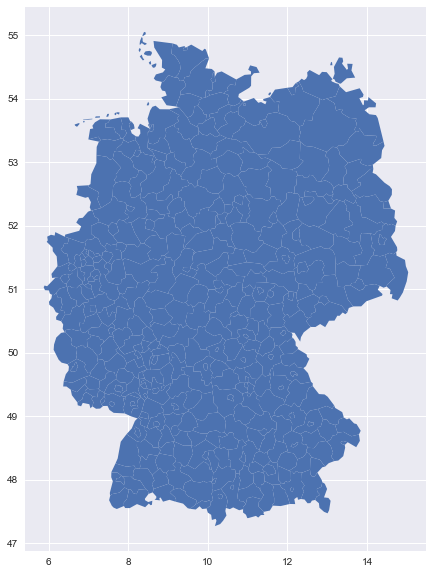

In [93]:
fp = "./NUTS_RG_10M_2021_4326_LEVL_3.shp/NUTS_RG_10M_2021_4326_LEVL_3.shp"
gdf_europe_lvl3 = gpd.read_file(fp)
gdf_ger_lvl3 = gdf_europe_lvl3[gdf_europe_lvl3['CNTR_CODE']=='DE']
display(gdf_ger_lvl3.head())
fig, ax = plt.subplots(1,1,figsize=(10,10))
gdf_ger_lvl3.plot(ax=ax);

In [148]:
gdf_isodontia_ger.crs = "epsg:4326"
occ_isodontia_with_adm3 = gpd.sjoin(gdf_isodontia_ger, gdf_ger_lvl3, how="left", op="within")
n_occs = occ_isodontia_with_adm3.NUTS_ID.value_counts()
gdf_ger_lvl3_occs = pd.merge(gdf_ger_lvl3, n_occs.to_frame(), left_on='NUTS_ID', right_index=True, how='right')
gdf_ger_lvl3_occs.rename(columns={'NUTS_ID_y':'isodontia_counts'}, inplace=True)

<AxesSubplot:>

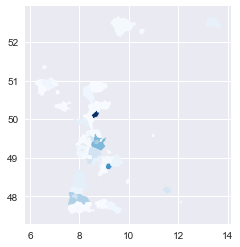

In [150]:
gdf_ger_lvl3_occs['isodontia_counts'] = gdf_ger_lvl3_occs['isodontia_counts'].fillna(0)
gdf_ger_lvl3_occs.plot(column='isodontia_counts', cmap="Blues")